In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from UsefulFunctions import *
import seaborn as sns
from config_path import MS_DATA_PATH, SEPSIS_PATH, HA_PATH
from dpks.quant_matrix import QuantMatrix
print(MS_DATA_PATH)

Base path: ..
../data/ms


In [4]:
long = pd.read_csv(f"{SEPSIS_PATH}/longitudinal_data.tsv", sep = "\t")
subtypes = pd.read_csv(f"{SEPSIS_PATH}/subtypes_data.tsv", sep = "\t")
design_matrix = pd.read_csv(f"{SEPSIS_PATH}/design_matrix_longitudinal.tsv", sep = "\t")
design_matrix['Sample'] = design_matrix['Sample'].str.replace('.osw','')
design_matrix['Subtype'].replace(1, '1', inplace=True)
design_matrix['Subtype'].replace(2, '2', inplace=True)

design_matrix_na = design_matrix[~design_matrix['Subtype'].isin(["1","2"])]
na_samples = design_matrix_na['Sample'].values
design_matrix_nona = design_matrix[design_matrix['Subtype'].isin(["1","2"])]
nona_samples = design_matrix_nona['Sample'].values
design_matrix.fillna('Unidentifiable', inplace=True)


/tmp/ipykernel_1393/1120475891.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  design_matrix['Sample'] = design_matrix['Sample'].str.replace('.osw','')


/tmp/ipykernel_929/2125789810.py:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "annotate" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('../plots/general/LabelPie.jpg', annotate=True, dpi=300, bbox_inches='tight')


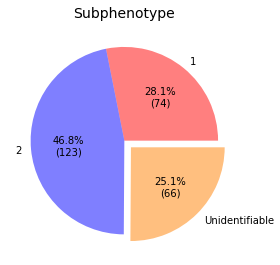

In [18]:

labels = design_matrix.groupby('Subtype').count()['Sample']
explode = [0, 0, 0.1]
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)
plt.figure(figsize=(4,4))
plt.pie(x=labels, labels=labels.index, colors=[(1,0,0,0.5), (0,0,1,0.5), (1,0.5,0,0.5)], autopct=lambda pct: func(pct, labels), explode=explode)
plt.title('Subphenotype', fontsize=14)
plt.tight_layout()
plt.savefig('../plots/general/LabelPie.jpg', annotate=True, dpi=300, bbox_inches='tight')

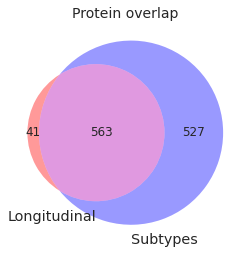

In [29]:
from matplotlib_venn import venn2

protein_long = set(long['Protein'].unique())
protein_sub = set(subtypes['Protein'].unique())
venn2([protein_long, protein_sub], ('Longitudinal', 'Subtypes'), ('red', 'blue'))
plt.title('Protein overlap', fontsize=14)
plt.savefig('../plots/general/ProteinVenn.jpg', dpi=300, bbox_inches='tight')

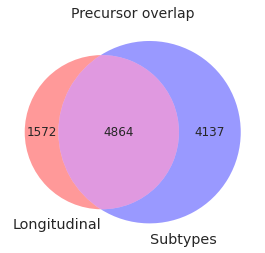

In [28]:
peptide_long = set(long['PeptideSequence'])
peptide_sub = set(subtypes['PeptideSequence'])
venn2([peptide_long, peptide_sub], ('Longitudinal', 'Subtypes'), ('red', 'blue'))
plt.title('Precursor overlap', fontsize=14)
plt.savefig('../plots/general/PrecursorVenn.jpg', dpi=300, bbox_inches='tight')

In [24]:
# subtypes = subtypes[
#             (subtypes["PeptideQValue"] <= 0.01)
#             & (subtypes["ProteinQValue"] <= 0.01)]
                    
# long = long[
#             (long["PeptideQValue"] <= 0.01)
#             & (long["ProteinQValue"] <= 0.01)]

inner = long.merge(subtypes, how='inner', on = ['PeptideSequence', 'Charge', 'Protein', 'Decoy'])
inner['RetentionTime'] = inner['RetentionTime_y']
inner['PeptideQValue'] = inner['PeptideQValue_y']
inner['ProteinQValue'] = inner['ProteinQValue_y']
print(len(inner['Protein'].unique()))
print(len(inner.index))
[c for c in inner.columns if c.endswith('x')]
inner.drop(columns=['RetentionTime_x', 'RetentionTime_y'
                    ,'PeptideQValue_x', 'PeptideQValue_y', 
                    'ProteinQValue_x', 'ProteinQValue_y'], inplace=True)
inner.drop(columns=na_samples, inplace=True)


554
7336


/tmp/ipykernel_929/867065712.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_out['count'] = 1
/tmp/ipykernel_929/867065712.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_out['Data subset'] = 'Excluded'
/tmp/ipykernel_929/867065712.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

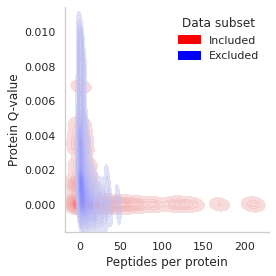

In [27]:
inner_proteins = inner['Protein'].values

long['in_inner'] = long['Protein'].apply(lambda x: True if x in inner_proteins else False)
subtypes['in_inner'] = subtypes['Protein'].apply(lambda x: True if x in inner_proteins else False)

long_out = long[long['in_inner'] == False]
subtypes_out = subtypes[subtypes['in_inner'] == False]

long_out['count'] = 1
long_out['Data subset'] = 'Excluded'
subtypes_out['count'] = 1
subtypes_out['Data subset'] = 'Excluded'
inner_temp = pd.DataFrame({'Protein':inner_proteins, 'PeptideQValue':inner['PeptideQValue'].values, 'ProteinQValue':inner['ProteinQValue'].values})
inner_temp['count'] = 1
inner_temp['Data subset'] = 'Included'

long_out = long_out[['Protein', 'Data subset', 'count', 'ProteinQValue']]
subtypes_out = subtypes_out[['Protein', 'Data subset', 'count', 'ProteinQValue']]
inner_temp = inner_temp[['Protein', 'Data subset', 'count' ,'ProteinQValue']]


df = pd.concat([long_out, subtypes_out, inner_temp])
df = df.groupby(['Protein','Data subset'], as_index=False).agg({'count':'sum','ProteinQValue':'mean'})
df.sort_values('Data subset', inplace=True, ascending=False)
#df['ProteinQValue'] = df['ProteinQValue'].apply(lambda x: -np.log(x))
plt.figure(figsize=(4,4))
sns.set(rc={'legend.frameon':False })
sns.set_style("whitegrid",{'axes.grid' : False, "axes.facecolor":"none"})
sns.kdeplot(data=df, x='count', y='ProteinQValue',
            levels=100, hue='Data subset',thresh=0.001, alpha=.5 , fill=True, bw_adjust=.75, palette=['red','blue'])

plt.xlabel('Peptides per protein')
plt.ylabel('Protein Q-value')
plt.tight_layout()
sns.despine()
plt.savefig('../plots/general/SubsetDensity.jpg', dpi=300, bbox_inches='tight')

In [206]:
inner.to_csv('../data/ms/inner.tsv', sep='\t', index=False)

design_matrix_nona['Group'] = design_matrix_nona['Subtype']
design_matrix_nona = design_matrix_nona[['Sample', 'Group']]
design_matrix_nona.to_csv('../data/ms/inner_design_matrix.tsv', sep='\t', index=False)

/tmp/ipykernel_2730/3889737988.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  design_matrix_nona['Group'] = design_matrix_nona['Subtype']


In [12]:


df = pd.read_csv(f'{MS_DATA_PATH}/inner.tsv', sep='\t')
design_matrix = pd.read_csv(f'{MS_DATA_PATH}/inner_design_matrix.tsv', sep='\t')

GroupOneCols = design_matrix[design_matrix['Group'] == 1]['Sample'].values
GroupTwoCols = design_matrix[design_matrix['Group'] == 2]['Sample'].values

print(len(GroupOneCols))
print(len(GroupTwoCols))

74
123


### Peptide distribution in samples

In [31]:
nr_unique_proteins = len(df['Protein'].unique())
print(f'# unique proteins: {nr_unique_proteins} ')

df['PeptideCount1'] = df[GroupOneCols].count(axis=1)
df['PeptideCount2'] = df[GroupTwoCols].count(axis=1)
df['PeptideCountSum'] = df['PeptideCount1']+df['PeptideCount2']
df['IntensitySum1'] = df[GroupOneCols].sum(axis=1)
df['IntensitySum2'] = df[GroupTwoCols].sum(axis=1)
df['IntensityMean1'] = df[GroupOneCols].mean(axis=1)
df['IntensityMean2'] = df[GroupTwoCols].mean(axis=1)
df['FC'] = df['IntensityMean1'] / df['IntensityMean2']
df['IntensitySum'] = df['IntensitySum1'] + df['IntensitySum2']

# unique proteins: 554 


### Protein level

## DPKS
---

In [3]:


quant_matrix = QuantMatrix(
    quantification_file=f"{SEPSIS_PATH}/inner.tsv",
    design_matrix_file=f"{SEPSIS_PATH}/inner_design_matrix.tsv"
)

qm = (
        quant_matrix
 # filter for q-values (removes rows with high q value (peptides), Q = 0.01) and removes decoys
        .normalize(method="mean", use_rt_sliding_window_filter=True) # best type of normalization is RT-sliding window
        .quantify(method="maxlfq", threads=12) # play around with minimum_subgroups (default is set 1)
    )
#qm.to_df().to_csv('../data/ms/QuantMatrix.csv', index=False)
# compare_df = qm.compare_groups(
#         method='linregress',
#         group_a=1,
#         group_b=2,
#         min_samples_per_group = 2, 
#         level='protein',
#     ).to_df()
# compare_df



/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/dpks/normalization.py:116: RuntimeWarning: Mean of empty slice
  sample_means = np.nanmean(X, axis=0)


In [16]:
compare_df = qm.compare_groups(
        method='linregress',
        group_a=1,
        group_b=2,
        min_samples_per_group = 2, 
        level='protein',
    ).to_df().dropna(subset=['CorrectedPValue'])

compare_df['logPValue'] = compare_df['PValues1-2'].apply(lambda x: -np.log(x))
compare_df['DifferentialExpression'] = (compare_df['logPValue']**2 + compare_df['Log2FoldChange1-2']**2)**0.5
compare_df.sort_values('DifferentialExpression', ascending=False)['Protein'][0:10]

148    P08571
232    P59665
153    P16070
163    P61769
114    P36955
78     P05362
139    Q86VB7
24     P01034
191    P15291
183    Q9NZP8
Name: Protein, dtype: object

In [2]:
#COVID
quant_matrix = QuantMatrix(
    quantification_file=f"../data/ms/covid/data_cropped.tsv",
    design_matrix_file=f"../data/ms/covid/design_cropped.tsv"
)

qm = quant_matrix.normalize(method="mean").quantify(method='maxlfq', threads=12)

In [3]:
compare_df = qm.compare_groups(
        method='linregress',
        group_a=1,
        group_b=2,
        min_samples_per_group = 2, 
        level='protein',
    ).to_df().dropna(subset=['CorrectedPValue'])
compare_df
compare_df['logPValue'] = compare_df['PValues1-2'].apply(lambda x: -np.log(x))
compare_df['DifferentialExpression'] = (compare_df['logPValue']**2 + compare_df['Log2FoldChange1-2']**2)**0.5
compare_df.sort_values('DifferentialExpression', ascending=False)['Protein'][0:10]

77     P09871
136    Q14624
33     P06396
160    P01011
88     P01833
29     P00736
59     P36955
240    P04083
71     P01009
62     P01034
Name: Protein, dtype: object

/tmp/ipykernel_929/3620353829.py:19: RuntimeWarning: divide by zero encountered in log10
  df_new['logI'] = [np.log10(x) for x in df_new['IntensitySum']]


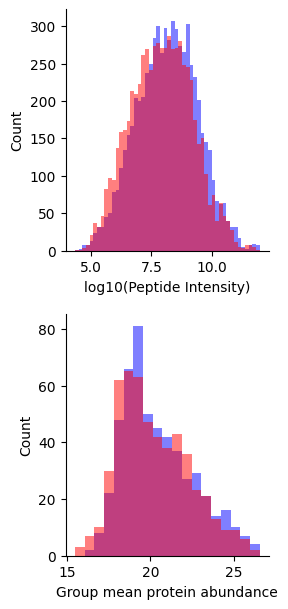

In [38]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
prot_df1 = compare_df[['Protein','Group1Mean']]
prot_df2 = compare_df[['Protein', 'Group2Mean']]
prot_df1 = prot_df1.rename(columns={'Group1Mean':'GroupMean'})
prot_df2 = prot_df2.rename(columns={'Group2Mean':'GroupMean'})
prot_df1['Group'] = 'Group 1'
prot_df2['Group'] = 'Group 2'

df1 = df[['PeptideSequence','IntensitySum1']]
df2 = df[['PeptideSequence', 'IntensitySum2']]
df1 = df1.rename(columns={'IntensitySum1':'IntensitySum'})
df2 = df2.rename(columns={'IntensitySum2':'IntensitySum'})
df1['Group'] = 'Group 1'
df2['Group'] = 'Group 2'

df_new = pd.concat([df1,df2])
df_new.reset_index(inplace=True)
df_new['logI'] = [np.log10(x) for x in df_new['IntensitySum']]
fig, ax = plt.subplots(2,1,figsize = (3,6), gridspec_kw={'height_ratios': [1, 1]})

sns.histplot(data=df_new, kde=False, x= 'logI', hue='Group', edgecolor=None, legend=False, palette=['red','blue'], alpha=0.5, ax=ax[0])
ax[0].set_xlabel('log10(Peptide Intensity)')
sns.despine()
plt.tight_layout()

prot_df_new = pd.concat([prot_df1,prot_df2])
prot_df_new.reset_index(inplace=True)
sns.histplot(data=prot_df_new, kde=False, x= 'GroupMean', hue='Group', edgecolor=None, legend=False, palette=['red','blue'], alpha=0.5, ax=ax[1])
ax[1].set_xlabel('Group mean protein abundance')

plt.savefig('../plots/general/PepProtHist.jpg', dpi=300, bbox_inches='tight')

437    P22894
232    P59665
483    P01780
151    P80511
75     P09110
272    P07327
231    P05121
305    P40925
286    Q14508
527    P14136
Name: Protein, dtype: object 437   -1.873562
232   -1.886861
483   -2.013733
151   -2.045454
75    -2.109422
272   -2.257273
231   -2.330115
305   -2.392732
286   -2.587528
527   -2.905592
Name: Log2FoldChange1-2, dtype: float64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


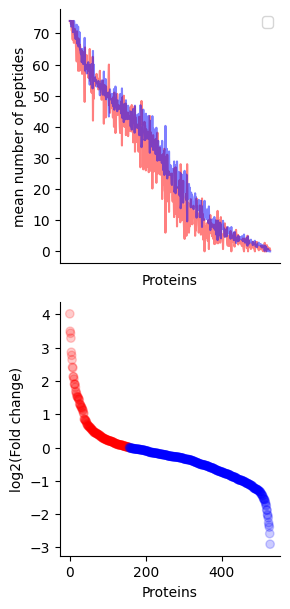

In [39]:
compare_df = compare_df.sort_values('Log2FoldChange1-2', ascending=False)
protein_peptide_count = df.groupby('Protein', as_index=False).mean()[['Protein','PeptideCount1','PeptideCount2','PeptideCountSum']]
compare_df_no_NaN = compare_df.dropna(subset=['Log2FoldChange1-2'])

def pltcolor(vals):
    cols=[]
    for y in vals:
        if y > 0:
            cols.append('red')
        else:
            cols.append('blue')
    return cols
colors = pltcolor(compare_df['Log2FoldChange1-2'].values)



groupratio = len(GroupOneCols)/len(GroupTwoCols)
protein_peptide_count = protein_peptide_count.sort_values('PeptideCountSum',ascending=False)
df1 = protein_peptide_count[['Protein','PeptideCount1']]
df2 = protein_peptide_count[['Protein', 'PeptideCount2']]
df1 = df1.rename(columns={'PeptideCount1':'PeptideCount'})
df2 = df2.rename(columns={'PeptideCount2':'PeptideCount'})
df1['Group'] = 'Group 1'
df2['Group'] = 'Group 2'
df2['PeptideCount'] = df2['PeptideCount'] * groupratio
df1['i'] = range(len(df1.index))
df2['i'] = range(len(df2.index))
df_new = pd.concat([df1,df2])
df_new.reset_index(inplace=True)

#print(compare_df_no_NaN[0:10].Protein, compare_df_no_NaN[0:10]['Log2FoldChange1-2'])
print(compare_df_no_NaN[len(compare_df_no_NaN.index)-10:len(compare_df_no_NaN.index)].Protein, 
      compare_df_no_NaN[len(compare_df_no_NaN.index)-10:len(compare_df_no_NaN.index)]['Log2FoldChange1-2'])



fig, ax = plt.subplots(2,1,figsize = (3,6), gridspec_kw={'height_ratios': [1, 1]})


sns.lineplot(data=df_new, x = 'Protein', y = 'PeptideCount', hue='Group', legend=False, palette=['red','blue'], alpha=0.5, ax=ax[0])

ax[0].set_xticks([])
#plt.xscale('log')
ax[0].set_xlabel('Proteins')
ax[0].set_ylabel('mean number of peptides')
ax[0].legend()
sns.despine(top=True, right=True, left=False, bottom=False)


g = ax[1].scatter(x=range(len(compare_df.index)),y=compare_df['Log2FoldChange1-2'], alpha=0.2,color=colors)
sns.despine()
ax[1].set_ylabel('log2(Fold change)')
plt.tight_layout()
ax[1].set_xlabel('Proteins')
plt.savefig('../plots/general/PeptideDistFC.jpg', bbox_inches='tight', dpi=300)


   color  count
0  black    264
1   blue      3
2    red      2
Group 1: 231.58362989323842 +- 7.4179460897490435 Group 2: 233.51231527093597 +- 6.7483693384543235


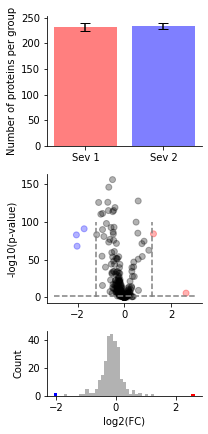

In [7]:

GroupOneCols = qm.get_samples(1)
GroupTwoCols = qm.get_samples(2)
compare_df['logPValue'] = compare_df['PValues1-2'].apply(lambda x: -np.log(x))
compare_df['color'] = compare_df.apply(lambda x: color_if_significant(x), axis=1)
compare_df['count'] = 1
print(compare_df.groupby('color', as_index=False).sum()[['color','count']])

fig, ax = plt.subplots(3,1,sharex=False, figsize = (3,6), gridspec_kw={'height_ratios': [2, 2,1]})

group1_proteins = []
for col in GroupOneCols:
    group1_proteins.append(compare_df[col].count())
group1_mean =  np.mean(group1_proteins)
group1_sd = np.std(group1_proteins)
group2_proteins = []
for col in GroupTwoCols:
    group2_proteins.append(compare_df[col].count())
group2_mean = np.mean(group2_proteins)
group2_sd = np.std(group2_proteins)

print(f"Group 1: {group1_mean} +- {group1_sd} Group 2: {group2_mean} +- {group2_sd}")


ax[1].scatter(x=compare_df['Log2FoldChange1-2'].values , y=compare_df['logPValue'].values, color=compare_df['color'].values, alpha=0.3)

ax[1].vlines(1.2, ymin=0, ymax=100, color='gray', linestyle='dashed')
ax[1].vlines(-1.2, ymin=0, ymax=100,color='gray', linestyle='dashed')
ax[1].hlines(1.31, xmin=-3, xmax=3, color='gray', linestyle='dashed')
ax[1].set_ylabel('-log10(p-value)')

g = sns.histplot(compare_df['Log2FoldChange1-2'].values, color='black',alpha=0.3, linewidth=0, ax = ax[2])
for p in range(len(g.patches)):
    x,_ = g.patches[p].xy
    if x < -2:
        g.patches[p].set_facecolor('blue')
    elif x > 2:
        g.patches[p].set_facecolor('red')

ax[2].set_ylabel('Count')
ax[2].set_xlabel('log2(FC)')



ax[0].bar(x = ['Sev 1', 'Sev 2'], height = [group1_mean,group2_mean], 
        yerr=[group1_sd, group2_sd], 
        capsize=5, 
        color=['red', 'blue'], 
        alpha=0.5,)
ax[0].set_ylabel('Number of proteins per group')

plt.tight_layout()

sns.despine(ax=ax[0])
sns.despine(ax=ax[1])
sns.despine(ax=ax[2])

plt.savefig('../plots/manuscript/covid_ProteinVolcanoHist.jpg', bbox_inches='tight', dpi=300)

In [10]:
quant_matrix = QuantMatrix(
    quantification_file=f"{MS_DATA_PATH}/sepsis/inner.tsv",
    design_matrix_file=f"{MS_DATA_PATH}/sepsis/inner_design_matrix.tsv"
)

precursor_compare_df = (quant_matrix.normalize(method="mean", use_rt_sliding_window=True).quantify(method='maxlfq', threads=12)).compare_groups(
        method='linregress',
        group_a=1,
        group_b=2,
        min_samples_per_group = 2, 
        level='precursor',
    ).to_df()
precursor_compare_df['logPValue'] = -1.0 * np.log10(precursor_compare_df['PValues1-2'])

Group 1: 3416.810810810811 +- 242.76719332190797 Group 2: 3509.308943089431 +- 325.6502221030926


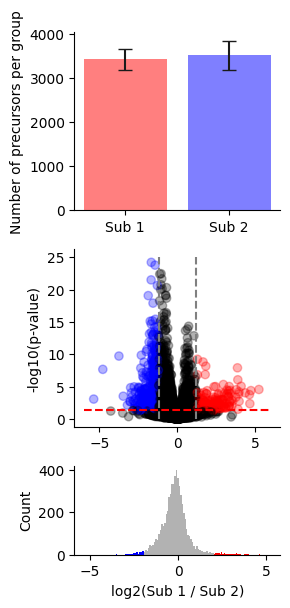

In [52]:

precursor_compare_df['color'] = precursor_compare_df.apply(lambda x: color_if_significant(x), axis=1)

group1_precursor = []
for col in GroupOneCols:
    group1_precursor.append(precursor_compare_df[col].count())
group1_mean =  np.mean(group1_precursor)
group1_sd = np.std(group1_precursor)
group2_precursor = []
for col in GroupTwoCols:
    group2_precursor.append(precursor_compare_df[col].count())
group2_mean = np.mean(group2_precursor)
group2_sd = np.std(group2_precursor)

print(f"Group 1: {group1_mean} +- {group1_sd} Group 2: {group2_mean} +- {group2_sd}")

fig, ax = plt.subplots(3,1, figsize = (3,6), gridspec_kw={'height_ratios': [2, 2,1]})
ax[1].scatter(x=precursor_compare_df['Log2FoldChange1-2'].values , y=precursor_compare_df['logPValue'].values, color=precursor_compare_df['color'].values, alpha=0.3)

ax[1].vlines(1.2, ymin=0, ymax=25, color='gray', linestyle='dashed')
ax[1].vlines(-1.2, ymin=0, ymax=25,color='gray', linestyle='dashed')
ax[1].hlines(1.31, xmin=-6, xmax=6, color='red', linestyle='dashed')
ax[1].set_ylabel('-log10(p-value)')

g = sns.histplot(precursor_compare_df['Log2FoldChange1-2'].values, color='black',alpha=0.3, linewidth=0, ax = ax[2])
for p in range(len(g.patches)):
    x,_ = g.patches[p].xy
    if x < -2:
        g.patches[p].set_facecolor('blue')
    elif x > 2:
        g.patches[p].set_facecolor('red')

ax[2].set_ylabel('Count')

ax[0].bar(x = ['Sub 1', 'Sub 2'], height = [group1_mean,group2_mean], 
        yerr=[group1_sd, group2_sd], 
        capsize=5, 
        color=['red', 'blue'], 
        alpha=0.5,)
ax[0].set_ylabel('Number of precursors per group')
ax[2].set_xlabel('log2(Sub 1 / Sub 2)')
plt.tight_layout()
sns.despine(ax=ax[0])
sns.despine(ax=ax[1])
sns.despine(ax=ax[2])
plt.savefig('../plots/general/PrecursorVolcanoHist.jpg', bbox_inches='tight', dpi=300)

In [14]:
theses = pd.read_csv('../old_theses.csv')

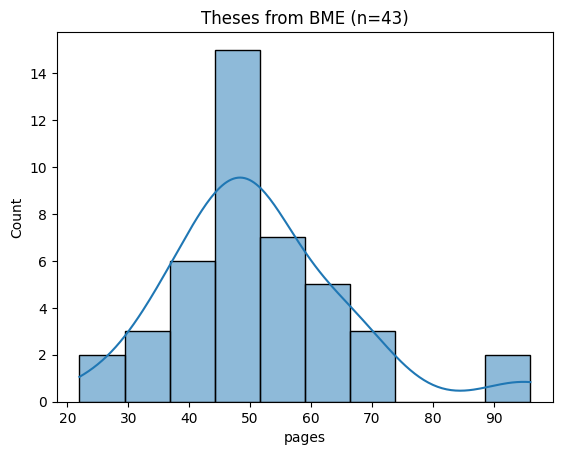

In [21]:
sns.histplot(data=theses, x='pages', bins=10, kde=True)
plt.title('Theses from BME (n=43)')
plt.savefig('BME.jpg', dpi=300)